# Best and worst molecules analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from scipy import stats
from torch.nn.utils.rnn import pad_sequence
from sklearn.neural_network import MLPRegressor
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.metrics import mean_squared_error, r2_score
import time

## Uploading data from file

In [2]:
DATA_PATH = "../../../data/4_best_predictions/"
FILE_PATTERN = "pa_transformer_predictions_{0}.csv"

In [3]:
valid = pd.read_csv(DATA_PATH + FILE_PATTERN.format('valid'))
test = pd.read_csv(DATA_PATH + FILE_PATTERN.format('test'))

In [4]:
compare_data = pd.DataFrame({'smiles': test.smiles, 'y_expected': test.logp, 'y_predicted': test.logp_pred})

In [5]:
X_valid_mol = [Chem.MolFromSmiles(x) for x in valid.smiles]
X_test_mol = [Chem.MolFromSmiles(x) for x in test.smiles]

In [6]:
y_test = test.logp
y_valid = valid.logp

## Getting the data to compare

In [7]:
compare_data.head()

,smiles,y_expected,y_predicted
0,CC(=O)NC(Cc1ccccc1)C(=O)NC(Cc1ccccc1)C(=O)N(C)...,2.63,2.323628
1,CC(C)n1c(/C=C/[C@@H](O)C[C@@H](O)CC(=O)O)c(-c2...,4.17,3.633403
2,CCS(=O)c1sc(C(C)=O)c(N)c1C#N,1.82,1.573192
3,O=P(Oc1ccccc1)(Oc1ccccc1)Oc1ccccc1,4.59,3.871765
4,OC1(c2cc(Cl)ccc2Cl)CCCCC1n1cncn1,3.24,3.237588


In [8]:
compare_data.shape

(2067, 3)

In [9]:
compare_data['error'] = (compare_data.y_expected - compare_data.y_predicted) ** 2

In [10]:
compare_data.sort_values(by=['error'], ascending=False).head()

,smiles,y_expected,y_predicted,error
1029,CCCCCCCCCCCCCCP(C)(C)(C)Br,2.06,8.517233,41.695858
1192,CN(CCO)c1nc(=Nc2ccc(C=Cc3ccc(N=c4[nH]c(N(C)CCO...,1.20,-2.420867,13.110676
1730,O=C(O[K])C1C2CCC(O2)C1C(=O)O[K],0.32,-3.074192,11.520538
1625,CCCC(=NOCC)C1C(=O)CC(C(C)CSCC)CC1=O,1.65,4.376903,7.436000
938,COc1ccc(C)cc1-n1nnnc1SCC(=O)Nc1cc(C(N)=O)cc(C(...,4.15,1.517720,6.928900


In [11]:
compare_data.sort_values(by=['error'], ascending=True).head()

,smiles,y_expected,y_predicted,error
288,COc1cc(-n2nc(C)cc2OC)nc(C)n1,1.54,1.540202,4.068289e-08
1743,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,3.51,3.509727,7.441984e-08
1027,Cc1cccc(CC(=O)O)c1,1.95,1.949701,8.964036e-08
1703,CC(=O)C=Cc1cccc(Br)c1,3.02,3.019667,1.108890e-07
1831,CCOc1ccc([N+](=O)[O-])cc1,2.53,2.529638,1.308269e-07


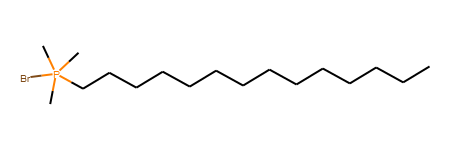

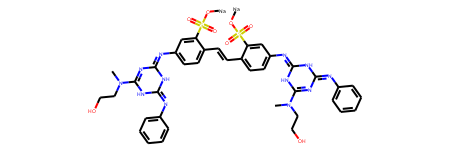

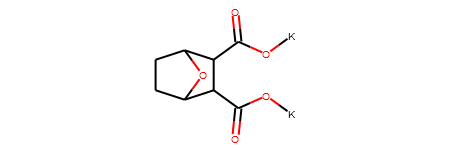

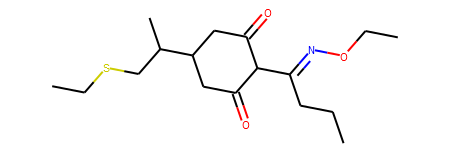

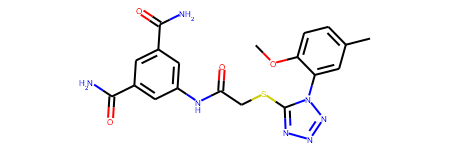

In [12]:
for mol in compare_data.sort_values(by=['error'], ascending=False).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

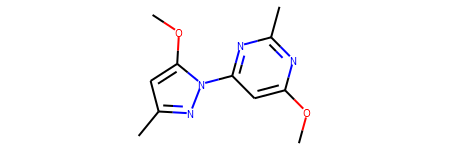

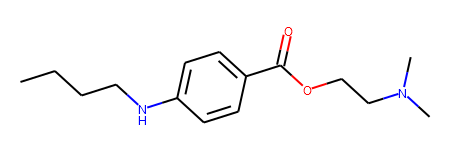

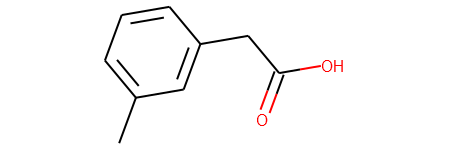

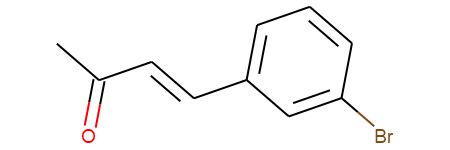

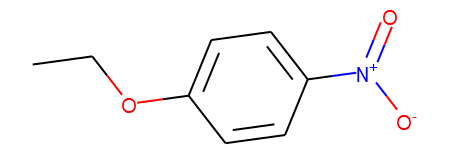

In [13]:
for mol in compare_data.sort_values(by=['error'], ascending=True).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

In [14]:
compare_data = compare_data.sort_values(by=['error'])

## Creating comparing function
### The features to compare:
- The count of atoms
- The count of rings
- The count of not organogens atoms
- The percent of not organogens atoms
- The percent of aromatic (benzene) rings out of all rings
- The count and percent of aromatic bonds
- The symmetry of molecules

In [15]:
def create_statistics(vals):
    values = vals.copy()
    mols = [Chem.MolFromSmiles(x) for x in values.smiles]
    
    atom_count = [mol.GetNumAtoms() for mol in mols]
    values['atom_count'] = pd.Series(atom_count)
    
    values['ring_count'] = pd.Series([mol.GetRingInfo().NumRings() for mol in mols])
    
    mol_atoms = [mol.GetAtoms() for mol in mols]
    non_simple_atom_count = [sum((num.GetAtomicNum() not in [1, 6, 8, 7]) for num in m_atoms) for m_atoms in mol_atoms]
    values['non_organogens_count'] = pd.Series(non_simple_atom_count)
    
    values['non_organogens_percent'] = values.non_organogens_count / values.atom_count *100
    
    benzene_smiles = 'C1=CC=CC=C1'
    pattern = Chem.MolFromSmiles(benzene_smiles)
    values['aromatic_count'] = pd.Series([len(mol.GetSubstructMatches(pattern)) for mol in mols])
    
    values['aromatic_rings_percent'] = values.aromatic_count / values.ring_count *100
    values['aromatic_rings_percent'] = values['aromatic_rings_percent'].fillna(0)
    
    values['bond_count'] =  [len(mol.GetBonds()) for mol in mols]
    values['aromatic_bond_count'] = [sum(bond.GetIsAromatic() for bond in mol.GetBonds()) for mol in mols]
    values['aromatic_bond_percent'] = values.aromatic_bond_count / values.bond_count * 100
    
    values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in mols]
    values['is_symmetric'] =  [(len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)])) for values in values_list]
    
    return values

## Analyzing the data features

In [16]:
compare_data_with_stats = create_statistics(compare_data)

In [17]:
compare_data_with_stats.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
288,COc1cc(-n2nc(C)cc2OC)nc(C)n1,1.54,1.540202,4.068289e-08,11,2,1,9.090909,0,0.0,18,11,61.111111,False
1743,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,3.51,3.509727,7.441984e-08,25,3,1,4.000000,3,100.0,19,6,31.578947,False
1027,Cc1cccc(CC(=O)O)c1,1.95,1.949701,8.964036e-08,20,2,1,5.000000,1,50.0,11,6,54.545455,False
1703,CC(=O)C=Cc1cccc(Br)c1,3.02,3.019667,1.108890e-07,24,1,0,0.000000,1,100.0,12,6,50.000000,False
1831,CCOc1ccc([N+](=O)[O-])cc1,2.53,2.529638,1.308269e-07,19,2,3,15.789474,1,50.0,12,6,50.000000,False


#### Splitting data into 3 parts

In [18]:
data = []
for i in range(3):
    data.append(compare_data_with_stats.take([j for j in range(i * 1894 // 3, min((i + 1) * 1894 // 3, 1894))]))

In [19]:
data[0].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,6.310000e+02,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,2.218162,2.220083,6.038843e-03,17.491284,1.754358,0.812995,4.885732,0.939778,56.299902,17.150555,7.529319,46.154189
std,1.755639,1.756821,5.596467e-03,7.711844,1.156710,1.363896,7.926305,0.749298,41.508624,8.217355,4.373297,23.752833
min,-3.400000,-3.285935,4.068289e-08,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,1.065000,1.036360,9.178599e-04,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,6.000000,33.333333
50%,2.040000,2.072831,4.511675e-03,16.000000,2.000000,0.000000,0.000000,1.000000,50.000000,16.000000,6.000000,46.153846
75%,3.225000,3.233038,1.020973e-02,21.000000,2.000000,1.000000,7.142857,1.000000,100.000000,20.000000,11.000000,63.157895
max,8.560000,8.664934,1.855834e-02,85.000000,8.000000,10.000000,47.619048,5.000000,100.000000,62.000000,27.000000,100.000000


In [20]:
data[1].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.00000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,2.18000,2.171987,0.053379,17.941363,1.822504,0.849445,5.237661,0.922345,51.971927,17.700475,7.645008,43.596761
std,1.71707,1.705850,0.025720,7.945532,1.246023,1.380532,8.877471,0.773771,40.922663,7.734523,4.826922,23.404015
min,-3.17000,-3.446675,0.018603,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,1.14000,1.110619,0.030430,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.000000,6.000000,31.578947
50%,2.13000,2.094722,0.049011,17.000000,2.000000,0.000000,0.000000,1.000000,50.000000,16.000000,6.000000,46.153846
75%,3.16000,3.085568,0.072699,21.000000,2.000000,1.000000,7.142857,1.000000,100.000000,21.000000,11.000000,57.979626
max,8.60000,8.337702,0.110734,62.000000,8.000000,9.000000,80.000000,5.000000,100.000000,65.000000,26.000000,100.000000


In [21]:
data[2].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,2.174905,2.172486,0.276800,17.737342,1.803797,0.881329,5.578867,0.960443,56.475663,19.159810,7.811709,41.746709
std,1.905245,1.889425,0.144651,7.881491,1.169929,1.316782,9.717694,0.751133,41.340845,8.203905,5.063244,23.898128
min,-3.700000,-3.160528,0.110956,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.902500,0.871087,0.155292,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,14.000000,6.000000,28.571429
50%,2.115000,2.097312,0.227232,16.000000,2.000000,0.000000,0.000000,1.000000,50.000000,18.000000,6.000000,42.857143
75%,3.415000,3.485075,0.366247,21.000000,2.000000,1.000000,7.692308,1.000000,100.000000,24.000000,11.000000,58.608321
max,8.030000,8.798494,0.643417,66.000000,9.000000,8.000000,100.000000,4.000000,100.000000,72.000000,28.000000,100.000000


## Check repeting patterns in the middle of the dataset
Hypothesis: badly predicted molecules are symmetric (like 1, 3, 5 worst molecules)

The simplest way to check: take 20 random molecules from the best/middle/worst part.

In [22]:
best = data[0].reset_index().drop(columns=['index'])

In [23]:
best.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,COc1cc(-n2nc(C)cc2OC)nc(C)n1,1.54,1.540202,4.068289e-08,11,2,1,9.090909,0,0.0,18,11,61.111111,False
1,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,3.51,3.509727,7.441984e-08,25,3,1,4.000000,3,100.0,19,6,31.578947,False
2,Cc1cccc(CC(=O)O)c1,1.95,1.949701,8.964036e-08,20,2,1,5.000000,1,50.0,11,6,54.545455,False
3,CC(=O)C=Cc1cccc(Br)c1,3.02,3.019667,1.108890e-07,24,1,0,0.000000,1,100.0,12,6,50.000000,False
4,CCOc1ccc([N+](=O)[O-])cc1,2.53,2.529638,1.308269e-07,19,2,3,15.789474,1,50.0,12,6,50.000000,False


In [24]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=10))

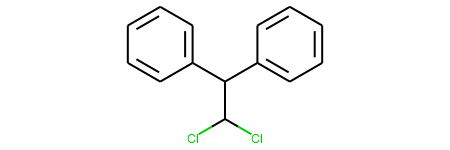

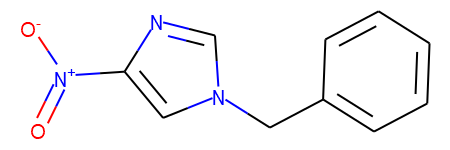

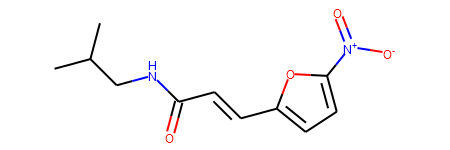

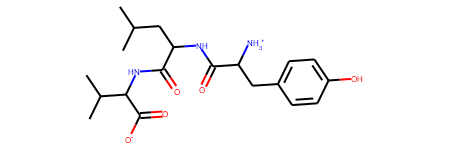

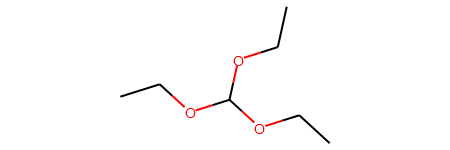

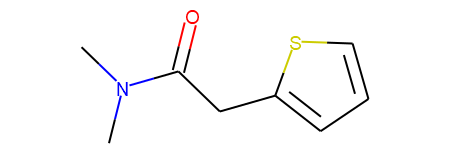

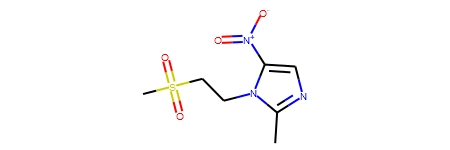

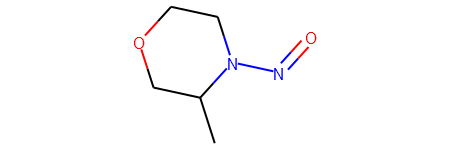

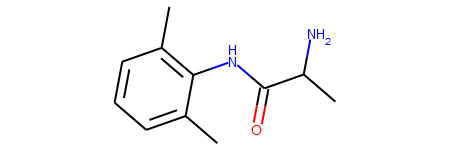

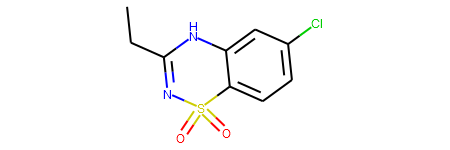

In [25]:
for smiles in best.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [26]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=20))

In [27]:
middle = data[1].reset_index().drop(columns=['index'])

In [28]:
middle.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,Brc1ccc(Br)cc1,3.79,3.653608,0.018603,13,1,0,0.0,1,100.0,8,6,75.000000,True
1,CCC(CC)COC(=O)N(C)C,2.87,2.733432,0.018651,23,2,0,0.0,1,50.0,11,0,0.000000,False
2,Clc1cc(Cl)cc(-c2cc(Cl)cc(Cl)c2)c1,6.60,6.463394,0.018661,17,1,0,0.0,1,100.0,17,12,70.588235,True
3,Clc1cc(Cl)c(Cl)c(-c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl)c1Cl,8.16,8.022666,0.018861,16,1,0,0.0,1,100.0,22,12,54.545455,False
4,CNC(=O)Oc1cccc(I)c1,2.52,2.382564,0.018889,13,1,0,0.0,0,0.0,12,6,50.000000,False


In [29]:
middle.shape

(631, 14)

In [30]:
indices = pd.Series(np.random.randint(631, size=10))

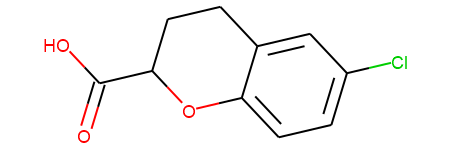

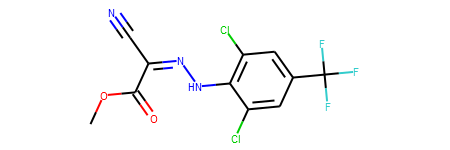

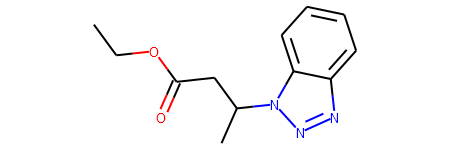

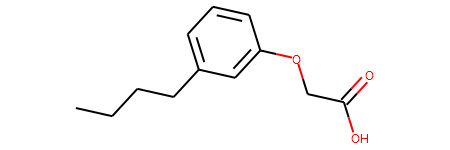

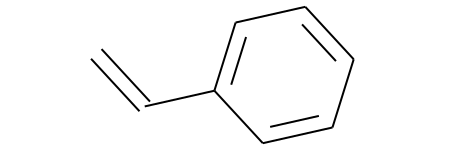

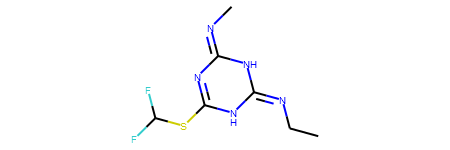

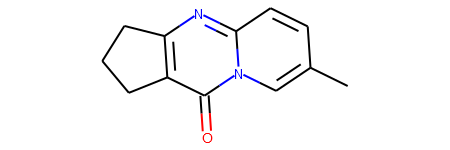

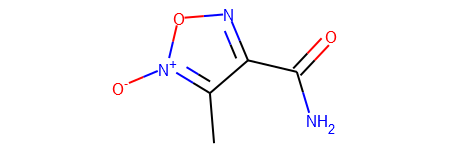

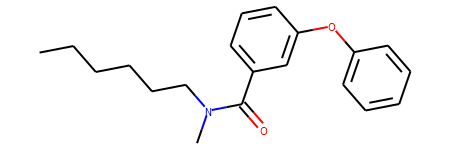

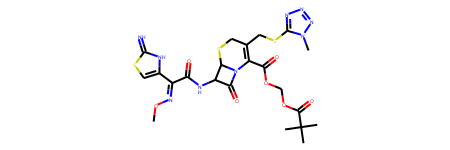

In [31]:
for smiles in middle.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [32]:
worst = data[2].reset_index().drop(columns=['index'])

In [33]:
indices = pd.Series(np.random.randint(631, size=10))

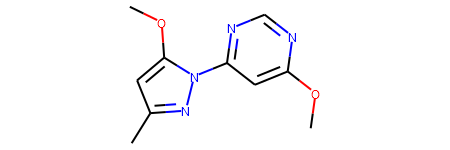

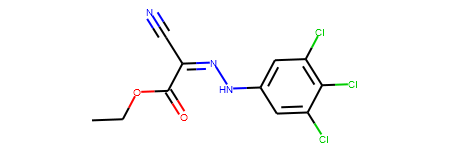

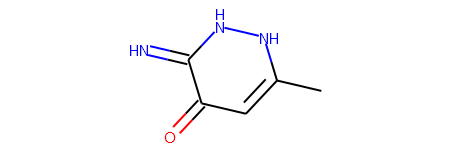

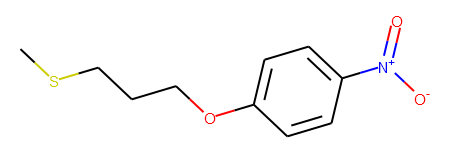

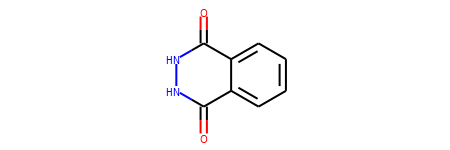

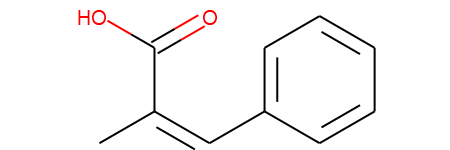

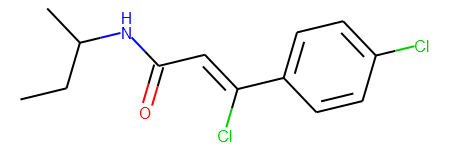

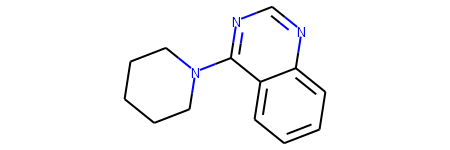

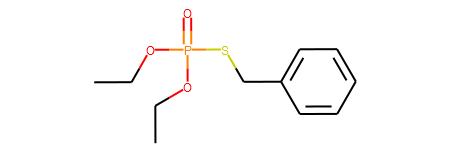

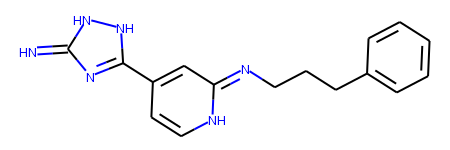

In [34]:
for smiles in worst.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

#### Taking best and worst predicted values

In [35]:
n_values = 200

In [36]:
best_n_vals = compare_data_with_stats.take([j for j in range(n_values)])

In [37]:
worst_n_vals = compare_data_with_stats.take([j for j in range( len(compare_data.smiles) - 1, len(compare_data.smiles) - 1 - n_values, -1)])

In [38]:
best_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
288,COc1cc(-n2nc(C)cc2OC)nc(C)n1,1.54,1.540202,4.068289e-08,11,2,1,9.090909,0,0.0,18,11,61.111111,False
1743,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,3.51,3.509727,7.441984e-08,25,3,1,4.000000,3,100.0,19,6,31.578947,False
1027,Cc1cccc(CC(=O)O)c1,1.95,1.949701,8.964036e-08,20,2,1,5.000000,1,50.0,11,6,54.545455,False
1703,CC(=O)C=Cc1cccc(Br)c1,3.02,3.019667,1.108890e-07,24,1,0,0.000000,1,100.0,12,6,50.000000,False
1831,CCOc1ccc([N+](=O)[O-])cc1,2.53,2.529638,1.308269e-07,19,2,3,15.789474,1,50.0,12,6,50.000000,False


In [39]:
worst_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
1029,CCCCCCCCCCCCCCP(C)(C)(C)Br,2.06,8.517233,41.695858,13,1,1,7.692308,1,100.0,18,0,0.000000,False
1192,CN(CCO)c1nc(=Nc2ccc(C=Cc3ccc(N=c4[nH]c(N(C)CCO...,1.20,-2.420867,13.110676,16,2,0,0.000000,0,0.0,67,36,53.731343,False
1730,O=C(O[K])C1C2CCC(O2)C1C(=O)O[K],0.32,-3.074192,11.520538,30,5,0,0.000000,1,20.0,16,0,0.000000,True
1625,CCCC(=NOCC)C1C(=O)CC(C(C)CSCC)CC1=O,1.65,4.376903,7.436000,14,2,1,7.142857,1,50.0,22,0,0.000000,False
938,COc1ccc(C)cc1-n1nnnc1SCC(=O)Nc1cc(C(N)=O)cc(C(...,4.15,1.517720,6.928900,13,2,2,15.384615,1,50.0,33,17,51.515152,False


In [40]:
best_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,200.000000,200.000000,2.000000e+02,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000
mean,2.209600,2.209204,4.845448e-04,17.21500,1.645000,0.770000,4.669021,0.890000,54.859524,17.20000,7.400000,45.171100
std,1.693683,1.697177,4.218557e-04,7.74459,1.111373,1.328883,7.774546,0.748801,42.819738,8.03635,4.095591,22.891445
min,-1.450000,-1.451897,4.068289e-08,5.00000,0.000000,0.000000,0.000000,0.000000,0.000000,4.00000,0.000000,0.000000
25%,1.007500,1.013632,8.889605e-05,12.00000,1.000000,0.000000,0.000000,0.000000,0.000000,12.00000,6.000000,33.333333
50%,2.080000,2.102471,4.012729e-04,16.00000,1.000000,0.000000,0.000000,1.000000,50.000000,16.00000,6.000000,46.153846
75%,3.280000,3.260056,7.838983e-04,21.00000,2.000000,1.000000,7.142857,1.000000,100.000000,19.00000,11.000000,60.277778
max,7.410000,7.417003,1.444783e-03,85.00000,7.000000,8.000000,47.058824,3.000000,100.000000,62.00000,22.000000,100.000000


In [41]:
worst_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1.934500,1.822607,1.703138,17.215000,1.74000,0.965000,5.997574,0.930000,54.027381,22.315000,8.155000,34.455727
std,2.266342,2.251652,3.272219,7.832979,1.24908,1.394092,8.975175,0.798931,41.697273,11.614658,7.093133,24.220594
min,-3.200000,-4.011827,0.577744,5.000000,0.00000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.285000,-0.012417,0.727066,12.000000,1.00000,0.000000,0.000000,0.000000,0.000000,15.000000,5.000000,16.340125
50%,1.980000,1.570557,0.945777,15.000000,1.00000,0.500000,1.351351,1.000000,50.000000,21.000000,6.000000,36.607143
75%,3.620000,3.541126,1.503807,20.000000,2.00000,1.000000,8.423913,1.000000,100.000000,26.000000,12.000000,52.173913
max,8.030000,8.798494,41.695858,62.000000,8.00000,8.000000,50.000000,4.000000,100.000000,85.000000,36.000000,88.235294


### Check atom_count influence

In [42]:
print(stats.ttest_ind(best_n_vals.atom_count, worst_n_vals.atom_count))

Ttest_indResult(statistic=0.0, pvalue=1.0)


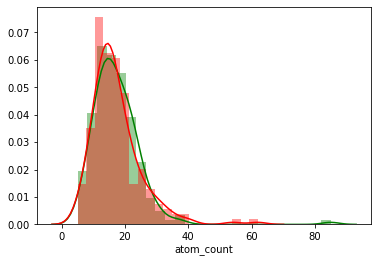

In [43]:
sns.distplot(best_n_vals.atom_count, color='g')
sns.distplot(worst_n_vals.atom_count, color='r')

### Check ring_count influence

In [44]:
print(stats.ttest_ind(best_n_vals.ring_count, worst_n_vals.ring_count))

Ttest_indResult(statistic=-0.8035638116135277, pvalue=0.42212858173672885)


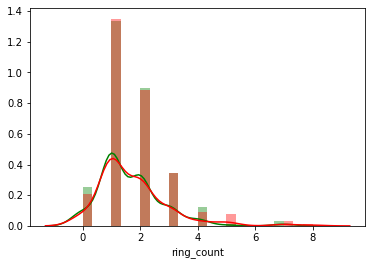

In [45]:
sns.distplot(best_n_vals.ring_count, color='g')
sns.distplot(worst_n_vals.ring_count, color='r')

### Check non_organogens_count influence

In [46]:
print(stats.ttest_ind(best_n_vals.non_organogens_count, worst_n_vals.non_organogens_count))

Ttest_indResult(statistic=-1.4318465619010952, pvalue=0.15297257014122126)


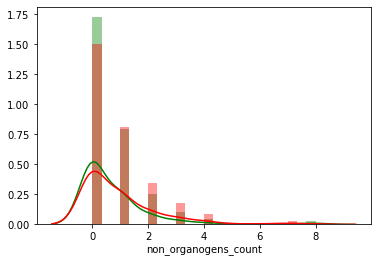

In [47]:
sns.distplot(best_n_vals.non_organogens_count, color='g')
sns.distplot(worst_n_vals.non_organogens_count, color='r')

### Check non_organogens_percent influence

In [48]:
print(stats.ttest_ind(best_n_vals.non_organogens_percent, worst_n_vals.non_organogens_percent))

Ttest_indResult(statistic=-1.5822986469019884, pvalue=0.11437570676069782)


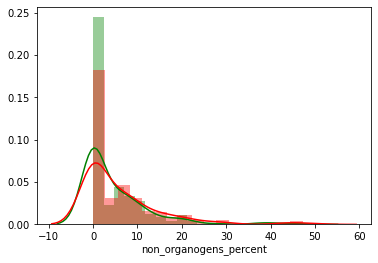

In [49]:
sns.distplot(best_n_vals.non_organogens_percent, color='g')
sns.distplot(worst_n_vals.non_organogens_percent, color='r')

### Check aromatic_count influence

In [50]:
print(stats.ttest_ind(best_n_vals.aromatic_count, worst_n_vals.aromatic_count))

Ttest_indResult(statistic=-0.5166141623990607, pvalue=0.6057124573972283)


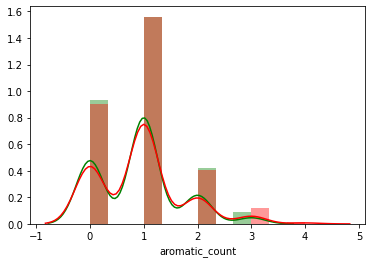

In [51]:
sns.distplot(best_n_vals.aromatic_count, color='g')
sns.distplot(worst_n_vals.aromatic_count, color='r')

### Check aromatic_rings_percent influence

In [52]:
print(stats.ttest_ind(best_n_vals.aromatic_rings_percent, worst_n_vals.aromatic_rings_percent))

Ttest_indResult(statistic=0.1968998819098411, pvalue=0.8440063944744817)


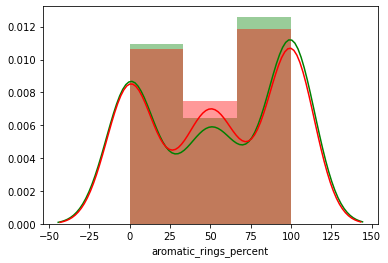

In [53]:
sns.distplot(best_n_vals.aromatic_rings_percent, color='g')
sns.distplot(worst_n_vals.aromatic_rings_percent, color='r')

### Check aromatic bond percent

In [54]:
print(stats.ttest_ind(best_n_vals.aromatic_bond_percent, worst_n_vals.aromatic_bond_percent))

Ttest_indResult(statistic=4.547080291175696, pvalue=7.229273026414917e-06)


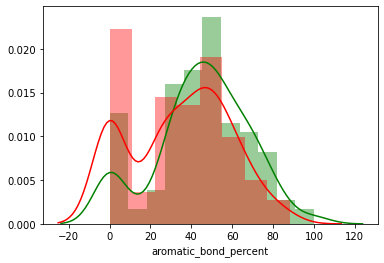

In [55]:
sns.distplot(best_n_vals.aromatic_bond_percent, color='g')
sns.distplot(worst_n_vals.aromatic_bond_percent, color='r')

### Check aromatic bond count

In [56]:
print(stats.ttest_ind(best_n_vals.aromatic_bond_count, worst_n_vals.aromatic_bond_count))

Ttest_indResult(statistic=-1.3036009942433708, pvalue=0.19312319734178118)


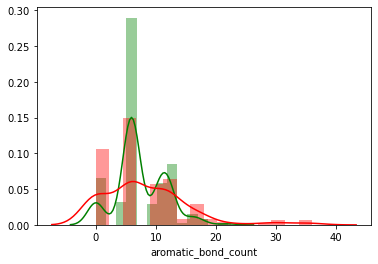

In [57]:
sns.distplot(best_n_vals.aromatic_bond_count, color='g')
sns.distplot(worst_n_vals.aromatic_bond_count, color='r')

### Check symmetric count

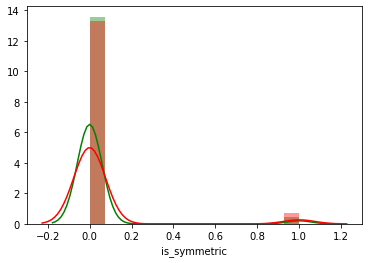

In [58]:
sns.distplot(best_n_vals.is_symmetric, color='g')
sns.distplot(worst_n_vals.is_symmetric, color='r')

### Metrics analysis among symmetric and not symmetric molecules

In [59]:
symmetric_rull = lambda values: (len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)]))

In [67]:
X_test_mol = [Chem.MolFromSmiles(x) for x in compare_data.smiles]

In [68]:
values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in X_test_mol]
symmetric_indices = [symmetric_rull(values) for values in values_list]
not_symmetric_indices = [not e for e in symmetric_indices]

In [69]:
symmetric_y_predicted = compare_data.y_predicted[symmetric_indices]

In [70]:
symmetric_y_expected = compare_data.y_expected[symmetric_indices]

In [71]:
not_symmetric_y_predicted = compare_data.y_predicted[not_symmetric_indices]

In [72]:
not_symmetric_y_expected = compare_data.y_expected[not_symmetric_indices]

In [73]:
print("Test symmetric RMSE =", mean_squared_error(symmetric_y_expected, symmetric_y_predicted, squared=False))
print("Test symmetric R2-score is {0}".format(r2_score(symmetric_y_expected, symmetric_y_predicted)))

Test symmetric RMSE = 0.7332186035164977
Test symmetric R2-score is 0.8985188741518493


In [74]:
print("Test not symmetric RMSE =", mean_squared_error(not_symmetric_y_expected, not_symmetric_y_predicted, squared=False))
print("Test not symmetric R2-score is {0}".format(r2_score(not_symmetric_y_expected, not_symmetric_y_predicted)))

Test not symmetric RMSE = 0.49968832921228606
Test not symmetric R2-score is 0.923587454307586
